<a href="https://colab.research.google.com/github/s208739v/robot_sim/blob/main/robot_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.patches as patches

In [78]:

STEP = 200
dt = 0.1
dx = 0.01
dy = dx

MAX_SPEED = 1


NUM_ROBOT = 10
NUM_CONTAINER = 1

MASS_ROBOT = 5.
MASS_CONTAINER = 100

MOMENT_OF_INERTIA_CONTAINER = 10000

SIZE_ROBOT = 0.

MU_FRICTION_ROBOT = 10
K = 200
g = 9.81

DTYPE = np.float64

C = 10 #速度依存の抵抗用


class Robot:
  ID = 0
  poss = []
  sizes = []
  dirs = []
  vs = []

  def __init__(self, mass=MASS_ROBOT,size=SIZE_ROBOT, type = "robot", position= np.array([0,0,0],dtype=DTYPE),target_id=0):
    self.id = self.ID
    self.ID+=1

    self.pos = np.array([0,0,0],dtype=DTYPE) #現在位置(x,y,z)
    self.pospre = self.pos #t-dtでの位置
    self.v = 0 #速さ
    self.theta = 0
    self.angular_v = 0

    self.F = np.array([0,0,0],dtype=DTYPE) #力ベクトル
    self.fn_sum = np.array([0,0,0],dtype=DTYPE) #接線方向の力
    self.dir = np.array([0,0,0],dtype=DTYPE) #進行方向ベクトル
    self.dn_pre = [np.array([0,0,0],dtype=DTYPE) for i in range(NUM_ROBOT+NUM_CONTAINER)]

    self.rot_amount = 0 #回転量。コンテナだけ使う

    self.target_id = target_id
    self.target = np.array([0,0,0],dtype=DTYPE) #マーカーの位置


    self.k = K #ペナルティ法のバネ定数

    self.type = type
    self.size = size
    self.mass = mass
    self.moment_of_inertia = MOMENT_OF_INERTIA_CONTAINER

    self.set_pos(position)
    self.poss.append(self.pos)
    self.sizes.append(self.size)
    self.dirs.append(self.dir)
    self.vs.append(self.v*self.dir)

  def set_pos(self,position):
    self.pos = position
    self.pospre = self.pos

  def evolution(self): #力を計算して運動方程式を解く
    self.solve_eom()

  def solve_eom(self): #運動方程式を解く. 

    F, momentum = self.calc_force(self.pos, self.v*self.dir) #力の計算

    self.pos, V = self.verlet(F, self.pos, self.v*self.dir,self.mass) #並進運動方程式を解く

    if self.type == "container": #回転運動
      self.theta, self.angular_v = self.verlet(momentum[2], self.theta, self.angular_v, self.moment_of_inertia)

    self.v = np.linalg.norm(V,ord=2)
    if self.v !=0:
      self.dir = V/self.v #進行方向ベクトルの算出
    else:
      self.dir = V #[0,0,0]
    
    self.dirs[self.id]=self.dir
    self.vs[self.id]=self.v

  def calc_force(self, x, v): #力の計算
    F = np.array([0,0,0],dtype=DTYPE)
    momentum = np.array([0,0,0],dtype=DTYPE)

    F += self.steering(x,v)
    F += self.resistance(x,v)
    f_c, momentum_c = self.detect_contact(x,v)
    F += f_c
    momentum += momentum_c
    self.F = F

    return F, momentum

  def detect_contact(self, x, v): #接触判定と接触力の計算
    f_contact = np.array([0,0,0],dtype=DTYPE)
    ft = np.array([0,0,0],dtype=DTYPE)
    fn = np.array([0,0,0],dtype=DTYPE)
    momentum = np.array([0,0,0],dtype=DTYPE)

    for i in range(NUM_ROBOT+NUM_CONTAINER):
      l = self.poss[i]-x #相対位置ベクトル
      l_norm =  np.linalg.norm(l) #距離
      d = (self.size+self.sizes[i])- l_norm #侵入量
      
      if d>0 and i!=self.id: #接触判定
        v = (self.v*self.dir)-self.vs[i]*self.dirs[i] #相対速度
        vt = np.dot(v,l)*l/(l_norm**2) #相対速度(法線方向)
        vn = v-vt #相対速度(接線方向)
        dn = self.dn_pre[i]+vn*dt #接線方向の侵入ベクトル

        if l_norm!=0: #大半の場合こっち完全に重心が重なったときはelseの方に
          ft += -self.k*d*l/l_norm #法線方向
          fn += -self.k*dn #接線方向
          f_contact += (fn+ft)

          if self.type == "container":
            momentum = np.cross(l,fn)

        else:
          f_contact+= -self.k*d*self.dirs[i]
          
      else: #接触していない場合、法線方向の変位をリセット
        self.dn_pre[i] = np.array([0,0,0],dtype=DTYPE)

    return f_contact, momentum

  def steering(self,x, v): #操舵力（入力）の計算
    #制御方法で分岐
    if self.type == "container": #制御なし。コンテナ
      return np.array([0,0,0],dtype=DTYPE)
    else:
      loc = x-self.target #目標位置（円軌道の中心）基準の座標
      loc_norm = loc/np.linalg.norm(loc)
      if self.target_id==1:
        tangent = self.rot_z(-90,loc_norm)
      elif self.target_id==2:
        tangent = self.rot_z(90,loc_norm)

      return 5.5*tangent -7.5*loc_norm 

  def resistance(self, x, v): #抵抗の計算
    return -C*v

  def stuck(self, x,y):
    
    return 2

  def verlet(self,f,x,v,mass):
    pos_next =x+ v*dt + 0.5*dt*dt*f/mass
    V = v + f/mass*dt
    return pos_next,V

  def runge_kutta(self,f,x,v):
    k1 = f
    x = x+1/2*v*dt
    v = v+1/2*k1/self.m*dt

    k2 = self.calc_force(x+1/2*v*dt, v+1/2*k1/self.m*dt)
    #k3 = self.calc_force()
    
  def set_target(self,t):
    self.target = t



  def rot_z(self,deg,vec): #z軸回りにベクトルを回転させる関数
    theta = np.pi/180*deg
    rot = np.array([[np.cos(theta),-np.sin(theta),0],
                   [np.sin(theta),np.cos(theta),0],
                   [0,0,1]],dtype = DTYPE)
    ans = np.dot(rot,vec)
    return ans



In [79]:
class Environment():
  def __init__(self):

    self.robots = [] #ロボットオブジェクトを入れるリスト
    self.path =[] #経路
    
    self.set_robots()
    self.set_path(np.array([0,-20,0],dtype=DTYPE),np.array([0,1000,0],dtype=DTYPE))

    self.update_poss_dir()


  def sim(self):

    self.fig, self.ax = plt.subplots(figsize=(6,6))
    ani = animation.FuncAnimation(self.fig, self.update, frames=range(STEP), interval=100)
    # アニメーションオブジェクトを変数に代入
    anim = HTML(ani.to_jshtml())
    # 変数に代入したアニメーションオブジェクトを表示する
    display(anim)
    anim.save()

  def test(self): #ロボット一個、コンテナ一個で挙動テスト
    self.fig, self.ax = plt.subplots(figsize=(6,6))
    ani = animation.FuncAnimation(self.fig, self.update, frames=range(STEP), interval=100)
    # アニメーションオブジェクトを変数に代入
    anim = HTML(ani.to_jshtml())
    # 変数に代入したアニメーションオブジェクトを表示する
    display(anim)

  def update(self,frame): #FuncAnimation内で実行される関数. ループさせる
    self.ax.cla()
    self.ax.set_xlim(-30,30)
    self.ax.set_ylim(-30,30)

    self.ax.plot([Robot.poss[i][0] for i in range(NUM_ROBOT+NUM_CONTAINER)], [Robot.poss[i][1] for i in range(NUM_ROBOT+NUM_CONTAINER)], '+')
    for i in range(NUM_ROBOT+NUM_CONTAINER):
      
      self.ax.quiver(self.robots[i].pos[0],self.robots[i].pos[1],self.robots[i].F[0]*10,self.robots[i].F[1]*10)
      c = patches.Circle(xy=(self.robots[i].pos[0], self.robots[i].pos[1]), radius=self.robots[i].size, fill=False, ec='r') #矢印の準備
      self.ax.add_patch(c)

      if i>=NUM_ROBOT: #コンテナの回転の可視化のために点をプロット
        self.ax.plot(self.robots[i].pos[0]+self.robots[i].size*np.cos(self.robots[i].theta)/2, self.robots[i].pos[1]+self.robots[i].size*np.sin(self.robots[i].theta)/2, "*")



      self.robots[i].evolution()
      self.update_target(self.robots[i])
    self.ax.plot(self.robots[0].target[0],self.robots[0].target[1] ,'+')
    self.ax.plot(self.robots[1].target[0],self.robots[1].target[1] ,'+')


    self.update_poss_dir()

  def set_robots(self): #robotオブジェクトを追加

    for i in range(NUM_ROBOT):
      if i%2 == 0:
        self.robots.append(Robot(position=np.array([20*(np.random.rand()-0.5),-20,0],dtype=DTYPE),target_id=1))
      else:
        self.robots.append(Robot(position=np.array([20*(np.random.rand()-0.5),-20,0],dtype=DTYPE),target_id=2))

    print(self.robots)
    for i in range(NUM_CONTAINER):
      self.robots.append(Robot(position=np.array([0,-1,0],dtype=DTYPE),mass=MASS_CONTAINER,size=10,type="container")) 

  def set_path(self,start,goal): #パスを設定
    vector = (goal-start)/50
    for i in range(50):
      self.path.append(start+vector*i)

  def update_poss_dir(self): #位置と進行方向をアップデート
    for i in range(NUM_ROBOT+NUM_CONTAINER):
      Robot.poss[i] = self.robots[i].pos
      Robot.dirs[i] = self.robots[i].dir

  def update_target(self,robot):
    i = self.nearest_point_index(self.path,Robot.poss[NUM_ROBOT])
    r = np.array([0,0,0],dtype=DTYPE)

    if robot.target_id == 1:
      r = self.rotz(-90,self.path[i+1]-self.path[i])
    elif robot.target_id == 2:
      r = self.rotz(90,self.path[i+1]-self.path[i])

    if np.linalg.norm(r) != 0:
      r = 20*r/np.linalg.norm(r)+self.path[i]
    robot.set_target(r)


  def nearest_point_index(self,points, target_point): #リスト内の座標から、ある座標に最も近い座標のインデックスを返す関数
    min_distance = float('inf')
    min_index = 0
    for i, point in enumerate(points):
        d = np.linalg.norm(point-target_point)
        if i == 0:
          min_distance = d
        if d < min_distance:
            min_distance = d
            min_index = i
    return min_index

  def rotz(self,deg,vec):
    theta = np.pi/180*deg
    rot = np.array([[np.cos(theta),-np.sin(theta),0],
                   [np.sin(theta),np.cos(theta),0],
                   [0,0,1]],dtype = DTYPE)
    ans = np.dot(rot,vec)
    return ans


[<__main__.Robot object at 0x7fcac9e0a310>, <__main__.Robot object at 0x7fcac9e0ab20>, <__main__.Robot object at 0x7fcac9e0adc0>, <__main__.Robot object at 0x7fcac9e0adf0>, <__main__.Robot object at 0x7fcac9e0a550>, <__main__.Robot object at 0x7fcac9e0a280>, <__main__.Robot object at 0x7fcac9e0a190>, <__main__.Robot object at 0x7fcac9e0a610>, <__main__.Robot object at 0x7fcac9e0a670>, <__main__.Robot object at 0x7fcac9e0a2b0>]


<ipython-input-78-c846f8565765>:120: RuntimeWarning: invalid value encountered in true_divide
  vt = np.dot(v,l)*l/(l_norm**2) #相対速度(法線方向)
/usr/local/lib/python3.9/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.9/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


AttributeError: ignored

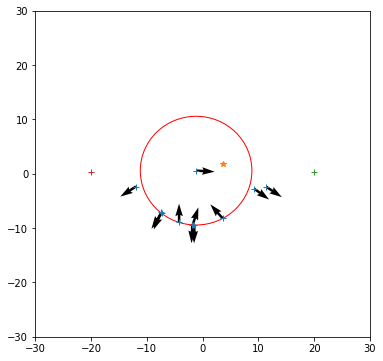

In [80]:
E = Environment()
E.sim()